### 1.5 Producer prices
#### 1.5.1 Data Description

The FAO Database offers a variety of datasets containing information about the consumer/producer prices of every country for all years between 1970 and 2018.
##### Producer prices -annual
<details>
  <summary>Description</summary> 
  This sub-domain contains data on Agriculture Producer Prices. These are prices received by farmers for primary crops, live animals and livestock primary products as collected at the point of initial sale (prices paid at the farm-gate). Annual data are provided from 1991 for over 160 countries and about 200 commodities.
</details>

<details>
  <summary>Path</summary>
  
  Data/FAOSTAT/Prices_E_All_Data_(Normalized).zip
</details>

##### Exchange rates -annual
<details>
  <summary>Description</summary>  
  Annual exchange rates, national currency units per U.S. dollar.
</details>

<details>
  <summary>Path</summary>  
  Data/FAOSTAT/Exchange_rate_E_All_Data_(Normalized).zip
</details>

##### Producer prices -monthly
<details>
  <summary>Description</summary>  
  This sub-domain contains data on Agriculture Producer Prices (APP). These are prices received by farmers for primary crops, live animals and livestock primary products as collected at the point of initial sale (prices paid at the farm-gate). Monthly data are provided from January 2010 to December of the previous year for over 60 countries and about 200 commodities.
</details>

<details>
  <summary>Path</summary>  
  Data/FAOSTAT/Prices_Monthly_E_All_Data_(Normalized).zip
</details>

##### Producer prices indices -annual
<details>
  <summary>Description</summary>  
  Indices of agricultural producer prices that measure the average annual change over time in the selling prices received by farmers (prices at the farm-gate or at the first point of sale). Annual data are provided for over 80 countries. The three categories of producer price indices available in FAOSTAT comprise: Single-item price indices, Commodity group indices and the Agriculture producer price index.
</details>

<details>
  <summary>Path</summary>  
  Data/FAOSTAT/Price_Indices_E_All_Data_(Normalized).zip
</details>

##### Producer prices -archive
<details>
  <summary>Description</summary>  
  This sub-domain contains data on Agriculture Producer Prices from 1966 to 1990. These are prices received by farmers for primary crops, live animals weight and livestock primary products as collected at the point of initial sale (prices paid at the farm-gate). Data are provided for over 97 countries and for some 200 commodities.
</details>

<details>
  <summary>Path</summary>  
  Data/FAOSTAT/PricesArchive_E_All_Data_(Normalized).zip
</details>

##### Consumer prices indices 
<details>
  <summary>Description</summary>  
  The FAOSTAT monthly CPI Food CPI database was based on the ILO CPI data until December 2014. In 2014, IMF-ILO-FAO agreed to transfer global CPI data compilation from ILO to IMF. Upon agreement, CPIs for all items and its sub components originates from the International Monetary Fund (IMF), and the UN Statistics Division(UNSD) for countries not covered by the IMF. However, due to a limited time coverage from IMF and UNSD for a number of countries, the Organisation for Economic Co-operation and Development (OECD), the Latin America and the Caribbean statistics (CEPALSTAT), Central Bank of Western African States (BCEAO), Eastern Caribbean Central Bank (ECCB) and national statistical office website data are used for missing historical data from IMF and UNSD food CPI. The FAO CPI dataset for all items(or general CPI) and the Food CPI, consists of a complete and consistent set of time series from January 2000 onwards. These indices measure the price change between the current and reference periods of the average basket of goods and services purchased by households. The CPI,all items is typically used to measure and monitor inflation, set monetary policy targets, index social benefits such as pensions and unemployment benefits, and to escalate thresholds and credits in the income tax systems and wages in public and private wage contracts.
</details>

<details>
  <summary>Path</summary>  
  Data/FAOSTAT/ConsumerPriceIndices_E_All_Data_(Normalized).zip
</details>

##### Deflators 
<details>
  <summary>Description</summary>  
  The FAOSTAT Deflators database provides the following selection of implicit price deflator series by country: Gross Domestic Product (GDP) deflator, Gross Fixed Capital Formation (GFCF) deflator, Agriculture, Forestry, Fishery Value-Added (VA_AFF) deflator, andManufacturing Valued-Added (VA_MAN) deflator. A deflator is a figure expressing the change in prices over a period of time for a product or a basket of products by comparing a reference period to a base period. It is obtained by dividing a current price value of a given aggregate by its real counterpart. When calculated from the major national accounting aggregates such as GDP or agriculture VA, implicit price deflators pertains to wider ranges of goods and services in the economy than that represented by any of the individual price indexes (such as CPIs, PPIs). Movements in an implicit price deflator reflect both changes in price and changes in the composition of the aggregate for which the deflator is calculated. In the FAOSTAT Deflators database, all series are derived from the United Nations Statistics Division (UNSD) National Accounts Estimates of Main Aggregates database (UNSD NAE). In particular, the implicit GDP deflator, the implicit GFCF deflator and the implicit value added deflator in Agriculture, Forestry, Fishery are obtained by dividing the series in current prices by those in constant 2010 prices (base year).
</details>

<details>
  <summary>Path</summary>  
  Data/FAOSTAT/Deflators_E_All_Data_(Normalized).zip
</details>

##### Inflation rate
<details>
  <summary>Description</summary>  
  Inflation rate of switzerland from 1991 to 2018.
</details>

<details>
  <summary>Path</summary>  
  Data/inflation_rate.csv
</details>

In this part we did analyse the producer prices for only one Item, the `Maize` item. We took the `Maize` Item because the quantity of Maize imported in Switzerland vary a lot. Hence, it could give us quite interesting results.
    To go in a bit more details, we evaluate the evolution in time of the price of Maize in Switzerland and compared it with different country groups: low income economies coutry, lower middle economies country, upper middle economies country and high income econimies countries.
    Finally, we tried to evaluate the infleuce of the quantity of Maize imported in Switzerland or exported from Switzerland with the producer prices.

#### 1.5.2 Data Cleaning

In [117]:
''' Load the data'''
prices_annual = pd.read_csv('Data/FAOSTAT/Prices_E_All_Data_(Normalized).zip', delimiter = ',', encoding = 'ISO-8859-1')
country_group = pd.read_csv('Data/FAOSTAT/country_group.csv', delimiter = ',', encoding = 'ISO-8859-1')
inflation_rate_swiss = pd.read_csv('Data/switzerland-inflation-rate.csv', sep=',', encoding = "ISO-8859-1")
exchange_rates = pd.read_csv('Data/FAOSTAT/Exchange_rate_E_All_Data_(Normalized).zip', delimiter = ',', encoding = 'ISO-8859-1')

In [118]:
prices_annual.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,221,"Almonds, with shell",5530,Producer Price (LCU/tonne),1993,1993,LCU,46000.0,NaN
1,2,Afghanistan,221,"Almonds, with shell",5530,Producer Price (LCU/tonne),1994,1994,LCU,50000.0,NaN
2,2,Afghanistan,221,"Almonds, with shell",5530,Producer Price (LCU/tonne),1995,1995,LCU,62000.0,NaN
3,2,Afghanistan,221,"Almonds, with shell",5530,Producer Price (LCU/tonne),1996,1996,LCU,50000.0,NaN
4,2,Afghanistan,221,"Almonds, with shell",5530,Producer Price (LCU/tonne),1997,1997,LCU,41000.0,NaN


In [119]:
country_group.head()

,Country Group Code,Country Group,Country Code,Country,M49 Code,ISO2 Code,ISO3 Code
0,5100,Africa,4,Algeria,12.0,DZ,DZA
1,5100,Africa,7,Angola,24.0,AO,AGO
2,5100,Africa,53,Benin,204.0,BJ,BEN
3,5100,Africa,20,Botswana,72.0,BW,BWA
4,5100,Africa,24,British Indian Ocean Territory,86.0,IO,IOT


In [120]:
inflation_rate_swiss.head()

,date,Inflation Rate,Annual Change
0,1991,5.8596,0.46
1,1992,4.0370,-1.82
2,1993,3.2926,-0.74
3,1994,0.8521,-2.44
4,1995,1.7998,0.95


In [121]:
exchange_rates.head()

,Area Code,Area,Item Code,Item,ISO Currency Code,Currency,Year Code,Year,Unit,Value,Flag,Note
0,2,Afghanistan,5540,Standard local currency units per USD,AFN,Afghani,1970,1970,NaN,0.045,X,Data from UNSD AMA
1,2,Afghanistan,5540,Standard local currency units per USD,AFN,Afghani,1971,1971,NaN,0.045,X,Data from UNSD AMA
2,2,Afghanistan,5540,Standard local currency units per USD,AFN,Afghani,1972,1972,NaN,0.045,X,Data from UNSD AMA
3,2,Afghanistan,5540,Standard local currency units per USD,AFN,Afghani,1973,1973,NaN,0.045,X,Data from UNSD AMA
4,2,Afghanistan,5540,Standard local currency units per USD,AFN,Afghani,1974,1974,NaN,0.045,X,Data from UNSD AMA


First of all we delete the flags as they are unecessary.

In [122]:
prices_annual = prices_annual.drop(columns = ['Flag'])
exchange_rates = exchange_rates.drop(columns = ['Flag'])

#### Exchange rates annual

In [123]:
exchange_rates.columns = exchange_rates.columns.str.replace(' ', '_')

Want to check if the exchange rates are always from local currency to dollars.

In [124]:
exchange_rates.Item.unique()

array(['Standard local currency units per USD'], dtype=object)

Check if Year_Code and Year are always the same

In [125]:
(exchange_rates.Year_Code - exchange_rates.Year).unique()

array([0])

They seem to be the same -> we can then delete one of the two

In [126]:
exchange_rates.drop(['Year_Code'], axis = 1, inplace = True)

In [127]:
exchange_rates.rename({'Value': 'Rate'}, axis = 1, inplace = True)

In [128]:
"""Select only necessary columns"""
exchange_rates = exchange_rates[['Area_Code', 'Area', 'Year', 'Rate']]
exchange_rates.drop_duplicates()
exchange_rates.head()

,Area_Code,Area,Year,Rate
0,2,Afghanistan,1970,0.045
1,2,Afghanistan,1971,0.045
2,2,Afghanistan,1972,0.045
3,2,Afghanistan,1973,0.045
4,2,Afghanistan,1974,0.045


Finally we want to know if the dataset contain nan values

In [129]:
exchange_rates.isnull().sum()

Area_Code    0
Area         0
Year         0
Rate         0
dtype: int64

Thus exchange_rates does not contain any nan values

#### Switzerland study

In [130]:
exchange_rates_swiss = exchange_rates.loc[exchange_rates.Area == 'Switzerland']

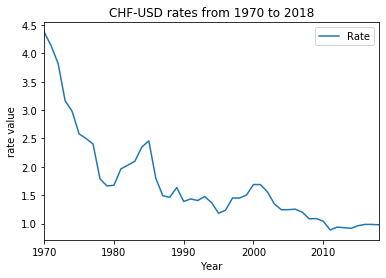

In [189]:
exchange_rates_swiss[['Rate', 'Year']].plot(kind = 'line', x = 'Year', y = 'Rate')
plt.title('CHF-USD rates from 1970 to 2018')
plt.ylabel('rate value')
plt.show()

When looking at the rates evolution from 1970 to 2018, everything seems to be correct without outliers. High rates are present in the 70's. From 2010 the USD and the CHF are almost equal which is also expected.

#### Producer prices

##### Producer prices -annual

In [132]:
prices_annual.columns = prices_annual.columns.str.replace(' ', '_')

In [133]:
''' Checking if the dataframe contains nan values'''
prices_annual.isnull().sum()

Area_Code       0
Area            0
Item_Code       0
Item            0
Element_Code    0
Element         0
Year_Code       0
Year            0
Unit            0
Value           0
dtype: int64

We also check if Year_Code and Year are the same

In [134]:
(prices_annual.Year_Code - prices_annual.Year).unique()

array([0])

There are the same so we keep one of the two

In [135]:
prices_annual.drop(['Year_Code'], axis = 1, inplace = True)

We finally want to know in which units are the prices

In [136]:
prices_annual['Unit'].unique()

array(['LCU', 'SLC', 'USD'], dtype=object)

In [137]:
prices_annual['Element'].unique()

array(['Producer Price (LCU/tonne)', 'Producer Price (SLC/tonne)',
       'Producer Price (USD/tonne)'], dtype=object)

In [138]:
prices_annual['Element_Code'].unique()

array([5530, 5531, 5532])

In [139]:
''' USD prices'''
prices_annual_usd = prices_annual.loc[prices_annual.Unit == 'USD']
prices_annual_usd.head()

,Area_Code,Area,Item_Code,Item,Element_Code,Element,Year,Unit,Value
722,3,Albania,515,Apples,5532,Producer Price (USD/tonne),1993,USD,461.1
723,3,Albania,515,Apples,5532,Producer Price (USD/tonne),1995,USD,323.6
724,3,Albania,515,Apples,5532,Producer Price (USD/tonne),1996,USD,325.4
725,3,Albania,515,Apples,5532,Producer Price (USD/tonne),1997,USD,253.1
726,3,Albania,515,Apples,5532,Producer Price (USD/tonne),1998,USD,248.9


In [140]:
''' Prices in LCU (local currency unit) unit'''
prices_annual_lcu = prices_annual.loc[prices_annual.Unit == 'LCU']
prices_annual_lcu.head()

,Area_Code,Area,Item_Code,Item,Element_Code,Element,Year,Unit,Value
0,2,Afghanistan,221,"Almonds, with shell",5530,Producer Price (LCU/tonne),1993,LCU,46000.0
1,2,Afghanistan,221,"Almonds, with shell",5530,Producer Price (LCU/tonne),1994,LCU,50000.0
2,2,Afghanistan,221,"Almonds, with shell",5530,Producer Price (LCU/tonne),1995,LCU,62000.0
3,2,Afghanistan,221,"Almonds, with shell",5530,Producer Price (LCU/tonne),1996,LCU,50000.0
4,2,Afghanistan,221,"Almonds, with shell",5530,Producer Price (LCU/tonne),1997,LCU,41000.0


In [141]:
''' Prices in SLC (standard local currency) unit'''
prices_annual_slc = prices_annual.loc[prices_annual.Unit == 'SLC']
prices_annual_slc.head()

,Area_Code,Area,Item_Code,Item,Element_Code,Element,Year,Unit,Value
18,2,Afghanistan,221,"Almonds, with shell",5531,Producer Price (SLC/tonne),1993,SLC,46000.0
19,2,Afghanistan,221,"Almonds, with shell",5531,Producer Price (SLC/tonne),1994,SLC,50000.0
20,2,Afghanistan,221,"Almonds, with shell",5531,Producer Price (SLC/tonne),1995,SLC,62000.0
21,2,Afghanistan,221,"Almonds, with shell",5531,Producer Price (SLC/tonne),1996,SLC,50000.0
22,2,Afghanistan,221,"Almonds, with shell",5531,Producer Price (SLC/tonne),1997,SLC,41000.0


In [142]:
''' 
Check if datasets containg LCU and SLC units are the same.
Unit, Element, Element_Code are columns referencing the unit used, we can then work without these columns 
for checking equality.
'''
prices_annual_slc.loc[prices_annual_slc.Unit == 'LCU'][prices_annual_slc.columns.difference(['Unit', 'Element', 'Element_Code'])].equals(prices_annual_lcu.loc[prices_annual_lcu.Unit == 'SLC'][prices_annual_lcu.columns.difference(['Unit', 'Element', 'Element_Code'])])


True

In [143]:
prices_annual_lcu_usd = prices_annual.loc[prices_annual.Unit == 'LCU'].merge(exchange_rates, left_on = ['Area_Code', 'Area', 'Year'], right_on = ['Area_Code', 'Area', 'Year'], suffixes=('', '_to_delete'))
prices_annual_lcu_usd['Value'] = prices_annual_lcu_usd['Value'] / prices_annual_lcu_usd['Rate']
prices_annual_lcu_usd.drop(columns = ['Rate'], inplace = True)
prices_annual_lcu_usd['Unit'] = 'USD'
prices_annual_lcu_usd['Element'] = 'Producer Price (USD/tonne)'
prices_annual_lcu_usd['Element_Code'] = 5532
prices_annual_lcu_usd.head()

,Area_Code,Area,Item_Code,Item,Element_Code,Element,Year,Unit,Value
0,2,Afghanistan,221,"Almonds, with shell",5532,Producer Price (USD/tonne),1993,USD,9.090909e+05
1,2,Afghanistan,515,Apples,5532,Producer Price (USD/tonne),1993,USD,1.205534e+05
2,2,Afghanistan,526,Apricots,5532,Producer Price (USD/tonne),1993,USD,5.731225e+05
3,2,Afghanistan,44,Barley,5532,Producer Price (USD/tonne),1993,USD,1.245059e+05
4,2,Afghanistan,767,Cotton lint,5532,Producer Price (USD/tonne),1993,USD,2.247775e+06


Until now will do a comparative study on the `Maize` item

In [144]:
prices_maize_usd = prices_annual_usd[prices_annual_usd['Item'] == 'Maize']

In [145]:
prices_maize_lcu_usd = prices_annual_lcu_usd[prices_annual_lcu_usd['Item'] == 'Maize']

We split the world in different groups to do comparisons. We splitted the world by their income economies.

In [146]:
groups = ['Low income economies', 'Lower-middle-income economies', 'Upper-middle-income economies', 'High-income economies']

In [147]:
country_group = country_group[['Country Group', 'Country']].drop_duplicates()
country_group = country_group[country_group['Country Group'].isin(groups)]

In [148]:
country_group = country_group.append({'Country Group': 'Switzerland', 'Country': 'Switzerland'}, ignore_index = True)

In [149]:
country_group.head()

,Country Group,Country
0,High-income economies,Andorra
1,High-income economies,Antigua and Barbuda
2,High-income economies,Argentina
3,High-income economies,Australia
4,High-income economies,Austria


`prices_group` dataframe contains only Maize Item, contains only dollars currency and `Value` correspond to the producer price of Maize in the `Area`.

In [150]:
prices_group_usd = country_group.merge(prices_maize_usd, left_on = 'Country', right_on = 'Area').drop(columns = ['Country'])
prices_group_usd.head()

,Country Group,Area_Code,Area,Item_Code,Item,Element_Code,Element,Year,Unit,Value
0,High-income economies,9,Argentina,56,Maize,5532,Producer Price (USD/tonne),1991,USD,94.3
1,High-income economies,9,Argentina,56,Maize,5532,Producer Price (USD/tonne),1992,USD,61.6
2,High-income economies,9,Argentina,56,Maize,5532,Producer Price (USD/tonne),1993,USD,108.1
3,High-income economies,9,Argentina,56,Maize,5532,Producer Price (USD/tonne),1994,USD,107.1
4,High-income economies,9,Argentina,56,Maize,5532,Producer Price (USD/tonne),1995,USD,115.0


To understand which data between local currency and dollar currency is more likely to not contain outliers, we will plot the distribution of the data.

In [151]:
prices_group_lcu_usd = prices_maize_lcu_usd.merge(country_group, left_on = 'Area', right_on = 'Country')
prices_group_lcu_usd.head()

,Area_Code,Area,Item_Code,Item,Element_Code,Element,Year,Unit,Value,Country Group,Country
0,2,Afghanistan,56,Maize,5532,Producer Price (USD/tonne),1993,USD,316205.533597,Low income economies,Afghanistan
1,2,Afghanistan,56,Maize,5532,Producer Price (USD/tonne),1994,USD,41166.784286,Low income economies,Afghanistan
2,2,Afghanistan,56,Maize,5532,Producer Price (USD/tonne),1995,USD,22200.888036,Low income economies,Afghanistan
3,2,Afghanistan,56,Maize,5532,Producer Price (USD/tonne),1996,USD,9880.000000,Low income economies,Afghanistan
4,2,Afghanistan,56,Maize,5532,Producer Price (USD/tonne),1997,USD,6000.000000,Low income economies,Afghanistan


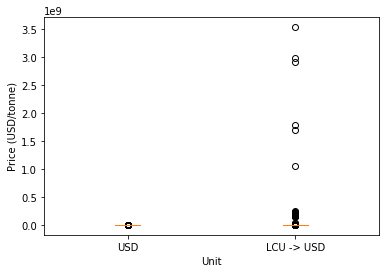

In [152]:
names = ['USD', 'LCU -> USD']
plt.boxplot([prices_group_usd['Value'], prices_group_lcu_usd['Value']])
plt.xticks([1, 2], names)
#plt.title('Comparison of prices between data directly in USD and data converted from LCU to USD from 1991 to 2018')
plt.xlabel('Unit')
plt.ylabel('Price (USD/tonne)')
plt.show()

We observe that values are much more plausible when they are directly in dollars. Even 0.5 with 1e9 is a very large number.
Then let's look only at the distribution of the dollar data again by doing a boxplot.

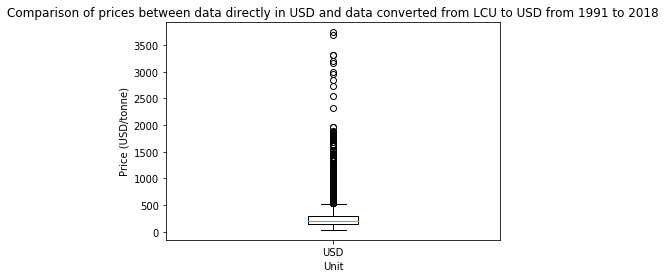

In [153]:
names = ['USD']
plt.boxplot([prices_group_usd['Value']])
plt.xticks([1], names)
plt.title('Comparison of prices between data directly in USD and data converted from LCU to USD from 1991 to 2018')
plt.xlabel('Unit')
plt.ylabel('Price (USD/tonne)')
plt.show()

We see few separate points.
Let's look at these points, data higher than 22 000 and investigate if these values can be justified.

In [154]:
prices_group_usd[prices_group_usd['Value'] > 2200]

,Country Group,Area_Code,Area,Item_Code,Item,Element_Code,Element,Year,Unit,Value
2247,Upper-middle-income economies,109,Jamaica,56,Maize,5532,Producer Price (USD/tonne),2008,USD,2742.0
2248,Upper-middle-income economies,109,Jamaica,56,Maize,5532,Producer Price (USD/tonne),2009,USD,2328.4
2249,Upper-middle-income economies,109,Jamaica,56,Maize,5532,Producer Price (USD/tonne),2010,USD,2852.6
2250,Upper-middle-income economies,109,Jamaica,56,Maize,5532,Producer Price (USD/tonne),2011,USD,3206.1
2251,Upper-middle-income economies,109,Jamaica,56,Maize,5532,Producer Price (USD/tonne),2012,USD,2988.1
2252,Upper-middle-income economies,109,Jamaica,56,Maize,5532,Producer Price (USD/tonne),2013,USD,2958.8
2253,Upper-middle-income economies,109,Jamaica,56,Maize,5532,Producer Price (USD/tonne),2014,USD,3167.6
2254,Upper-middle-income economies,109,Jamaica,56,Maize,5532,Producer Price (USD/tonne),2015,USD,3315.8
2255,Upper-middle-income economies,109,Jamaica,56,Maize,5532,Producer Price (USD/tonne),2016,USD,3317.1
2256,Upper-middle-income economies,109,Jamaica,56,Maize,5532,Producer Price (USD/tonne),2017,USD,3688.0


Jamaica seems to always have high producer prices, so we can think it is not a outlier. But what about the producer prices of Suriname for other years than 2015.

In [155]:
prices_group_usd[prices_group_usd['Area'] == 'Suriname']

,Country Group,Area_Code,Area,Item_Code,Item,Element_Code,Element,Year,Unit,Value
2598,Upper-middle-income economies,207,Suriname,56,Maize,5532,Producer Price (USD/tonne),1991,USD,393.9
2599,Upper-middle-income economies,207,Suriname,56,Maize,5532,Producer Price (USD/tonne),1992,USD,320.7
2600,Upper-middle-income economies,207,Suriname,56,Maize,5532,Producer Price (USD/tonne),1993,USD,241.9
2601,Upper-middle-income economies,207,Suriname,56,Maize,5532,Producer Price (USD/tonne),1994,USD,150.2
2602,Upper-middle-income economies,207,Suriname,56,Maize,5532,Producer Price (USD/tonne),1995,USD,338.8
2603,Upper-middle-income economies,207,Suriname,56,Maize,5532,Producer Price (USD/tonne),1996,USD,598.5
2604,Upper-middle-income economies,207,Suriname,56,Maize,5532,Producer Price (USD/tonne),1997,USD,635.0
2605,Upper-middle-income economies,207,Suriname,56,Maize,5532,Producer Price (USD/tonne),1998,USD,946.2
2606,Upper-middle-income economies,207,Suriname,56,Maize,5532,Producer Price (USD/tonne),1999,USD,479.6
2607,Upper-middle-income economies,207,Suriname,56,Maize,5532,Producer Price (USD/tonne),2000,USD,381.9


The producer prices seems to gradually increase by reaching a maximum at the year 2015 and then decreasing. Consequently, this value does not come from nowhere and we can keep the `Maize` data as it is.

#### Analyses of datasets

We want to analyse producer prices between the different country groups, we thus average the `Value` for each group giving a average producer price for each group.

In [156]:
prices_group_usd = prices_group_usd.groupby(['Country Group', 'Year']).mean().reset_index()
prices_group_usd.head()

,Country Group,Year,Area_Code,Item_Code,Element_Code,Value
0,High-income economies,1991,122.476190,56.0,5532.0,221.095238
1,High-income economies,1992,125.909091,56.0,5532.0,212.695455
2,High-income economies,1993,131.538462,56.0,5532.0,226.776923
3,High-income economies,1994,130.296296,56.0,5532.0,224.722222
4,High-income economies,1995,130.037037,56.0,5532.0,276.629630


We define a function pct_change that computes the percentage evolution compare to the first year of the given group. The first year will then have a `Value` of 0. We define it has a function because we will use quite often.

In [157]:
def pct_change(df, new_col, exist_col):
    df[new_col] = (df[exist_col] - df.iloc[0][exist_col]) / (df.iloc[0][exist_col])
    return df

In [158]:
# We make sure that the year are sorted in increasing order, and call the pct_change function for each country group
prices_group_usd = prices_group_usd.sort_values(['Year']).groupby(['Country Group']).apply(pct_change, 'Value_pct', 'Value')
prices_group_usd.head()

,Country Group,Year,Area_Code,Item_Code,Element_Code,Value,Value_pct
0,High-income economies,1991,122.476190,56.0,5532.0,221.095238,0.0
28,Low income economies,1991,133.000000,56.0,5532.0,232.150000,0.0
84,Switzerland,1991,211.000000,56.0,5532.0,523.000000,0.0
56,Lower-middle-income economies,1991,107.105263,56.0,5532.0,176.910526,0.0
112,Upper-middle-income economies,1991,119.818182,56.0,5532.0,223.786364,0.0


In [159]:
# To have a better representation to what Value_pct represent.
prices_group_usd[prices_group_usd['Country Group'] == 'High-income economies']

,Country Group,Year,Area_Code,Item_Code,Element_Code,Value,Value_pct
0,High-income economies,1991,122.476190,56.0,5532.0,221.095238,0.000000
1,High-income economies,1992,125.909091,56.0,5532.0,212.695455,-0.037992
2,High-income economies,1993,131.538462,56.0,5532.0,226.776923,0.025698
3,High-income economies,1994,130.296296,56.0,5532.0,224.722222,0.016405
4,High-income economies,1995,130.037037,56.0,5532.0,276.629630,0.251179
5,High-income economies,1996,130.037037,56.0,5532.0,284.074074,0.284849
6,High-income economies,1997,130.037037,56.0,5532.0,237.477778,0.074097
7,High-income economies,1998,130.037037,56.0,5532.0,213.962963,-0.032259
8,High-income economies,1999,130.037037,56.0,5532.0,185.111111,-0.162754
9,High-income economies,2000,134.535714,56.0,5532.0,169.003571,-0.235607


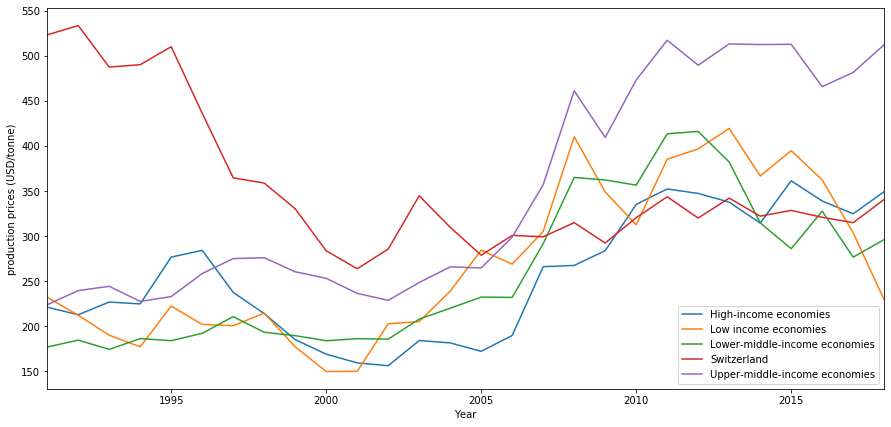

In [188]:
#Plot showing prices in the different country groups from 1991 to 2018.
fig, ax = plt.subplots(figsize=(15,7))
for group in prices_group_usd['Country Group'].unique():
    prices_group_usd[prices_group_usd['Country Group'] == group].set_index(['Year']).unstack()['Value'].plot(ax = ax, label = group)
    ax.legend()
plt.ylabel('production prices (USD/tonne)')
plt.show()

Same plot as before but this time using `Value_pct` as the y axis.

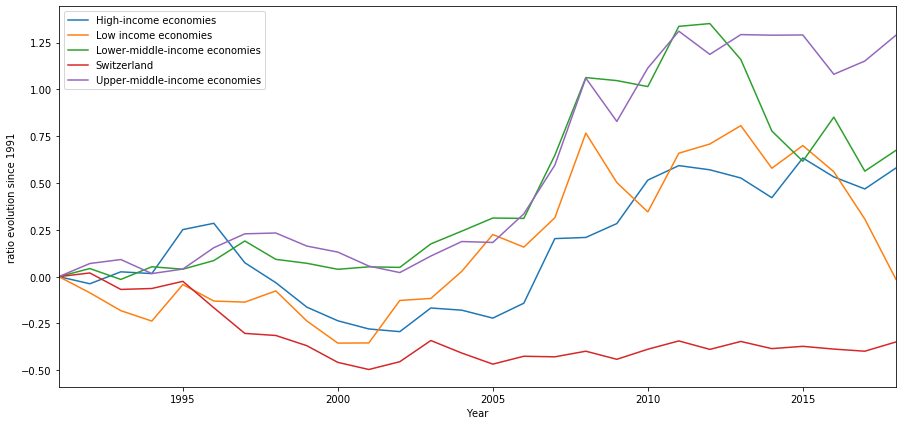

In [193]:
#Plot showing prices in the different country groups from 1991 to 2018.
fig, ax = plt.subplots(figsize=(15,7))
for group in prices_group_usd['Country Group'].unique():
    prices_group_usd[prices_group_usd['Country Group'] == group].set_index(['Year']).unstack()['Value_pct'].plot(ax = ax, label = group)
    ax.legend()
plt.ylabel('ratio evolution since 1991')
plt.show()

To be able to counter the effect of inflation rate of monney, we think of a min max scaling as normalization.

In [162]:
scaling = prices_group_usd.groupby(['Year']).min()[['Value']].reset_index()[['Year', 'Value']].rename({'Value': 'Min'}, axis = 1)
scaling['Max'] = prices_group_usd.groupby(['Year']).max()[['Value']].reset_index()['Value']
scaling.head()

,Year,Min,Max
0,1991,176.910526,523.0
1,1992,184.555000,533.3
2,1993,174.268421,487.3
3,1994,177.094444,489.9
4,1995,183.934783,509.9


In [163]:
# combine `prices_group_usd` and `scaling` in order to do the min max scaling
prices_group_usd = prices_group_usd.merge(scaling, left_on = 'Year', right_on = 'Year')
# min-max scaling
prices_group_usd['Value_Normalize'] = (prices_group_usd['Value'] - prices_group_usd['Min']) / (prices_group_usd['Max'] - prices_group_usd['Min'])
prices_group_usd = prices_group_usd.drop(columns = ['Min', 'Max']).sort_values(['Country Group', 'Year'])
prices_group_usd.head()

,Country Group,Year,Area_Code,Item_Code,Element_Code,Value,Value_pct,Value_Normalize
0,High-income economies,1991,122.476190,56.0,5532.0,221.095238,0.000000,0.127668
8,High-income economies,1992,125.909091,56.0,5532.0,212.695455,-0.037992,0.080691
13,High-income economies,1993,131.538462,56.0,5532.0,226.776923,0.025698,0.167742
16,High-income economies,1994,130.296296,56.0,5532.0,224.722222,0.016405,0.152260
22,High-income economies,1995,130.037037,56.0,5532.0,276.629630,0.251179,0.284370


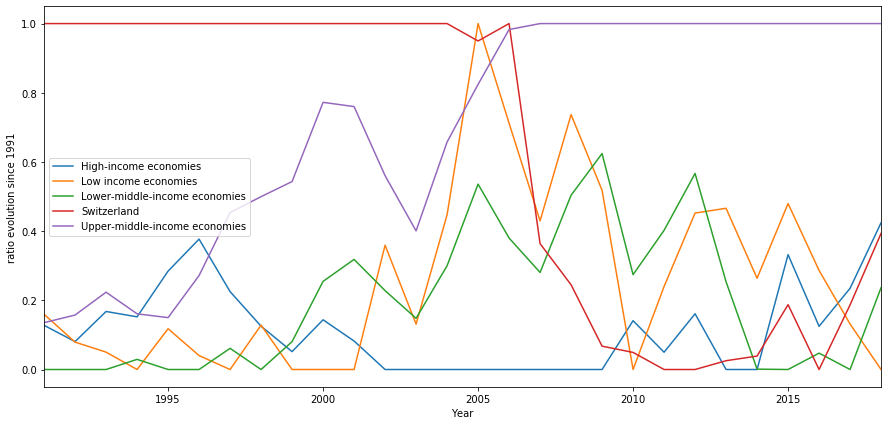

In [192]:
#Plot showing prices in the different country groups from 1991 to 2018.
fig, ax = plt.subplots(figsize=(15,7))
for group in prices_group_usd['Country Group'].unique():
    prices_group_usd[prices_group_usd['Country Group'] == group].set_index(['Year']).unstack()['Value_Normalize'].plot(ax = ax, label = group)
    ax.legend()
plt.ylabel('ratio evolution since 1991')
plt.show()

After having computed the min max scaling, we plotted the result. However, we do not see any advantages of doing it this way. Therefore, we had to leave this idea.
The next step on our analysis is to ask thr question: Is there a correlation between producer prices and qunantity of importation/ exportation

For that, we again only use the `Maize` case. We start at 1992 as there is no values for the quantity of exports for `Maize` in 1991.

In [165]:
# This dataframe gives the quantity (in tonne) of Maize imported in Switzerland.
maize_swiss_imports = imports_quant_df_CH[imports_quant_df_CH['Item'] == 'Maize'].groupby('Year').sum()['Value'].reset_index()
maize_swiss_imports.head()

,Year,Value
0,1986,167028.0
1,1987,173959.0
2,1988,174777.0
3,1989,97961.0
4,1990,75446.0


In [166]:
# This dataframe gives the quantity (in tonne) of Maize exported by Switzerland
maize_swiss_exports = exports_quant_df_CH[exports_quant_df_CH['Item'] == 'Maize'].groupby('Year').sum()['Value'].reset_index()
maize_swiss_exports.head()

,Year,Value
0,1986,5.0
1,1988,1.0
2,1989,22.0
3,1990,431.0
4,1991,114.0


In [167]:
# We look only at years greater or equal to 1992.
maize_swiss_imports = maize_swiss_imports[maize_swiss_imports['Year'] > 1991]
maize_swiss_imports = pct_change(maize_swiss_imports, 'Value_pct_imports', 'Value').rename({'Value': 'Value_imports'}, axis = 1)
maize_swiss_imports.head()

,Year,Value_imports,Value_pct_imports
6,1992,35491.0,0.000000
7,1993,33587.0,-0.053647
8,1994,37354.0,0.052492
9,1995,30497.0,-0.140712
10,1996,49180.0,0.385703


In [168]:
# We look only at years greater or equal to 1992.
maize_swiss_exports = maize_swiss_exports[maize_swiss_exports['Year'] > 1991]
maize_swiss_exports = pct_change(maize_swiss_exports, 'Value_pct_exports', 'Value').rename({'Value': 'Value_exports'}, axis = 1)
maize_swiss_exports.head()

,Year,Value_exports,Value_pct_exports
5,1992,38.0,0.000000
6,1993,129.0,2.394737
7,1994,54.0,0.421053
8,1995,24.0,-0.368421
9,1996,25.0,-0.342105


In [169]:
# merge prices_group_usd and maize_swiss_imports and maize_swiss_exports to have all the values in a single dataframe.
cor_imports_prices_swiss = prices_group_usd[prices_group_usd['Country Group'] == 'Switzerland'].merge(maize_swiss_imports, left_on = ['Year'], right_on = ['Year'], suffixes = ('_prices', '_imports'))
cor_imports_exports_prices_swiss = cor_imports_prices_swiss.merge(maize_swiss_exports, left_on = 'Year', right_on = 'Year')
cor_imports_exports_prices_swiss.head()

,Country Group,Year,Area_Code,Item_Code,Element_Code,Value,Value_pct,Value_Normalize,Value_imports,Value_pct_imports,Value_exports,Value_pct_exports
0,Switzerland,1992,211.0,56.0,5532.0,533.3,0.019694,1.0,35491.0,0.000000,38.0,0.000000
1,Switzerland,1993,211.0,56.0,5532.0,487.3,-0.068260,1.0,33587.0,-0.053647,129.0,2.394737
2,Switzerland,1994,211.0,56.0,5532.0,489.9,-0.063289,1.0,37354.0,0.052492,54.0,0.421053
3,Switzerland,1995,211.0,56.0,5532.0,509.9,-0.025048,1.0,30497.0,-0.140712,24.0,-0.368421
4,Switzerland,1996,211.0,56.0,5532.0,436.1,-0.166157,1.0,49180.0,0.385703,25.0,-0.342105


We will add another column to `cor_imports_exports_prices_swiss` which will represent the producer prices, taking into account the inflation rate.

In [170]:
cor_imports_exports_prices_swiss['Value_infl'] = cor_imports_exports_prices_swiss['Value'] * (1 + inflation_rate_swiss['Inflation Rate'])

In [171]:
cor_imports_exports_prices_swiss.head()

,Country Group,Year,Area_Code,Item_Code,Element_Code,Value,Value_pct,Value_Normalize,Value_imports,Value_pct_imports,Value_exports,Value_pct_exports,Value_infl
0,Switzerland,1992,211.0,56.0,5532.0,533.3,0.019694,1.0,35491.0,0.000000,38.0,0.000000,3658.22468
1,Switzerland,1993,211.0,56.0,5532.0,487.3,-0.068260,1.0,33587.0,-0.053647,129.0,2.394737,2454.53010
2,Switzerland,1994,211.0,56.0,5532.0,489.9,-0.063289,1.0,37354.0,0.052492,54.0,0.421053,2102.94474
3,Switzerland,1995,211.0,56.0,5532.0,509.9,-0.025048,1.0,30497.0,-0.140712,24.0,-0.368421,944.38579
4,Switzerland,1996,211.0,56.0,5532.0,436.1,-0.166157,1.0,49180.0,0.385703,25.0,-0.342105,1220.99278


In [172]:
# add the percentage changes into the dataframe
cor_imports_exports_prices_swiss = pct_change(cor_imports_exports_prices_swiss, 'Value_pct_infl', 'Value_infl')
cor_imports_exports_prices_swiss.head()

,Country Group,Year,Area_Code,Item_Code,Element_Code,Value,Value_pct,Value_Normalize,Value_imports,Value_pct_imports,Value_exports,Value_pct_exports,Value_infl,Value_pct_infl
0,Switzerland,1992,211.0,56.0,5532.0,533.3,0.019694,1.0,35491.0,0.000000,38.0,0.000000,3658.22468,0.000000
1,Switzerland,1993,211.0,56.0,5532.0,487.3,-0.068260,1.0,33587.0,-0.053647,129.0,2.394737,2454.53010,-0.329038
2,Switzerland,1994,211.0,56.0,5532.0,489.9,-0.063289,1.0,37354.0,0.052492,54.0,0.421053,2102.94474,-0.425146
3,Switzerland,1995,211.0,56.0,5532.0,509.9,-0.025048,1.0,30497.0,-0.140712,24.0,-0.368421,944.38579,-0.741846
4,Switzerland,1996,211.0,56.0,5532.0,436.1,-0.166157,1.0,49180.0,0.385703,25.0,-0.342105,1220.99278,-0.666234


Plotting results ...

Switzerlandproduction prices compare to quantity of Maize imported in Switzerland


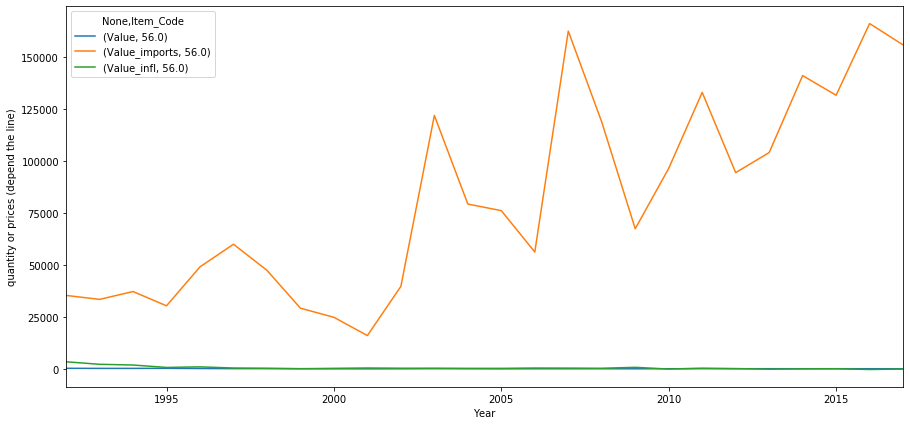

In [185]:
for group in cor_imports_exports_prices_swiss['Country Group'].unique():
    print(group + 'production prices compare to quantity of Maize imported in Switzerland')
    fig, ax = plt.subplots(figsize=(15,7))
    cor_imports_exports_prices_swiss[cor_imports_prices_swiss['Country Group'] == group].set_index(['Year', 'Item_Code']).unstack()[['Value', 'Value_imports', 'Value_infl']].plot(ax = ax)
    plt.ylabel('quantity or prices (depend the line)')
    plt.show()

The order of magnitude of the quantity of ``Maize`` imported in Switzerland is way too high compare to the producer prices per tonnes and the prices taking into account the inflation rate.
To counter this effect we decided to plot the evolution in percentage of each variable compare to first year that we have: 1991.

Switzerlandprodcution prices compare to quantity of Maize imported in Switzerland


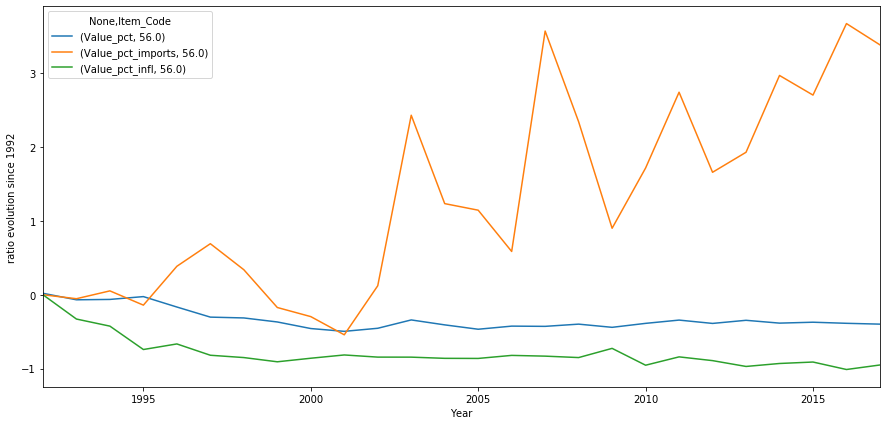

In [191]:
for group in cor_imports_exports_prices_swiss['Country Group'].unique():
    print(group + 'prodcution prices compare to quantity of Maize imported in Switzerland')
    fig, ax = plt.subplots(figsize=(15,7))
    cor_imports_exports_prices_swiss[cor_imports_exports_prices_swiss['Country Group'] == group].set_index(['Year', 'Item_Code']).unstack()[['Value_pct', 'Value_pct_imports', 'Value_pct_infl']].plot(ax = ax)
    plt.ylabel('ratio evolution since 1992')
    plt.show()

Switzerlandproduction prices compare to quantity of Maize exported from Switzerland


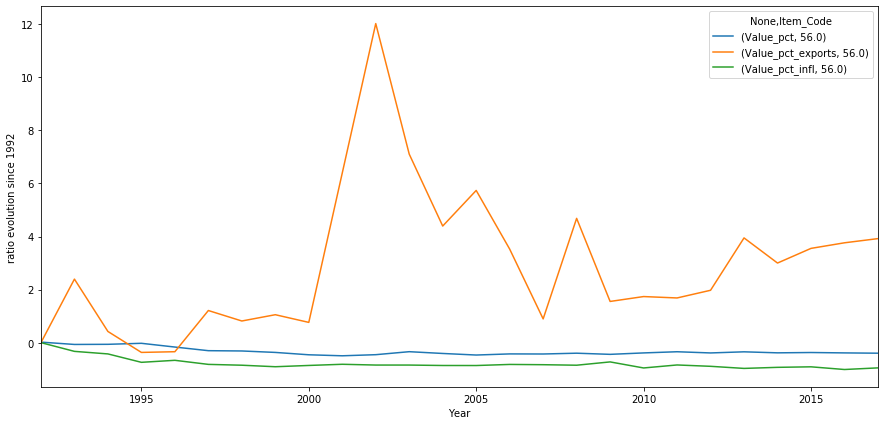

In [190]:
for group in cor_imports_exports_prices_swiss['Country Group'].unique():
    print(group + 'production prices compare to quantity of Maize exported from Switzerland')
    fig, ax = plt.subplots(figsize=(15,7))
    cor_imports_exports_prices_swiss[cor_imports_exports_prices_swiss['Country Group'] == group].set_index(['Year', 'Item_Code']).unstack()[['Value_pct', 'Value_pct_exports', 'Value_pct_infl']].plot(ax = ax)
    plt.ylabel('ratio evolution since 1992')
    plt.show()